# Alireza Rashidi CI HW_3

## Data Preprations:

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp /content/drive/MyDrive/Datasets/train.zip /content/sample_data

In [6]:
!mkdir /content/CIHW3_Datasets
!unzip /content/sample_data/train.zip -d /content/CIHW3_Datasets

Archive:  /content/sample_data/train.zip
  inflating: /content/CIHW3_Datasets/train.csv  


In [7]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import datetime
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
import torch.nn as nn
from torch import optim
from torch.nn.functional import one_hot
from torchvision import transforms
# from torchvision.transforms import ToTensor
from tqdm import tqdm
from matplotlib import pyplot as plt

In [8]:
emotions = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'
}

df = pd.read_csv('/content/CIHW3_Datasets/train.csv')
df

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...
28704,2,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705,0,114 112 113 113 111 111 112 113 115 113 114 11...
28706,4,74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707,0,222 227 203 90 86 90 84 77 94 87 99 119 134 14...


In [9]:
# torch.cuda.is_available()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


In [10]:
df.groupby('emotion').count()     # printing class frequencies.

,pixels
emotion,
0,3995
1,436
2,4097
3,7215
4,4830
5,3171
6,4965


## Custom Dataset + data augmentation

In [11]:
images = []
pixels = df['pixels']

# --------------------- pure tensor -------------------------------
for row in tqdm(range(len(pixels))):
    images.append([ int(x) for x in pixels[row].split(" ") ] )

100%|██████████| 28709/28709 [00:16<00:00, 1709.92it/s]


In [125]:
# this custom dataset used in order to batch data(with specific size) and preprocess each sample in run time.
class EmotionDetection_Dataset(torch.utils.data.Dataset):

    def __init__(self, X, y, transform=None, sample_size=(48, 48), num_classes=7, target_transform=True):
        self.X = torch.tensor(X)
        self.y = one_hot( torch.tensor(y), num_classes=num_classes) if target_transform else torch.tensor(y)  # one hot encoding for better classification accuracy
        self.transform = transform
        self.sample_size = sample_size

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        image = image.reshape(1, self.sample_size[0], self.sample_size[1]) 
        label = self.y[idx]

        if self.transform:   # normalize each sample dynamicly
            image = image / 255.
            image = self.transform(image)

        return image, label


In [126]:
#### data augmentation part
torchvision_transform = transforms.Compose([
        transforms.RandomCrop(48, padding=4, padding_mode='reflect'),     
        transforms.RandomRotation(15),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.01, 0.12),
            shear=(0.01, 0.03),
        ),
        transforms.RandomHorizontalFlip(),
])
emotion_dataset = EmotionDetection_Dataset(images, df['emotion'], transform=torchvision_transform, target_transform=True)
print(len(emotion_dataset))

28709


## Data Visualizations:

Label:  Surprise


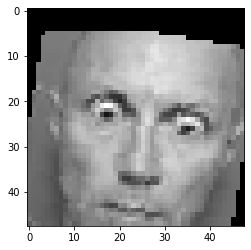

In [127]:
sample_idx = 15;
# plt.imshow(torch.squeeze( torch.transpose(train_X_tensor[sample_idx], 0, 2), 2 ) )
plt.imshow(torch.squeeze(emotion_dataset[sample_idx][0]), cmap="gray")
print('Label: ', emotions[emotion_dataset[sample_idx][1].argmax().item()])

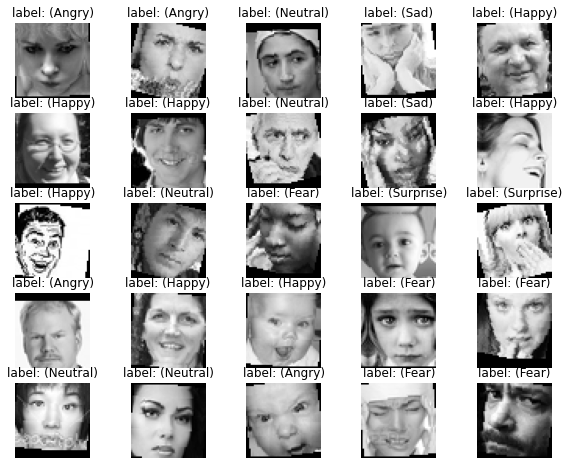

In [128]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(emotion_dataset), size=(1,)).item()
    img, label = emotion_dataset[sample_idx][0], emotions[emotion_dataset[sample_idx][1].argmax().item()]
    figure.add_subplot(rows, cols, i)
    plt.title('label: ({})'.format(label))
    plt.axis("off")
    plt.imshow(img.reshape(48, 48), cmap="gray")
plt.show()

## Train_validation_split:

In [129]:
random_seed = 42
torch.manual_seed(random_seed);

train_set_size = int(len(emotion_dataset) * 0.9)  # 90% for train and 10% for validation
valid_set_size = len(emotion_dataset) - train_set_size
train_set, valid_set = random_split(emotion_dataset, [train_set_size, valid_set_size])

In [130]:
print('train set len: ', len(train_set))
print('validation set len: ', len(valid_set))

train set len:  25838
validation set len:  2871


## Using Pytorch Dataloader for batching data:

In [131]:
# batching data + creating dataloader object for training CNN in pytorch framework. 
batch_size = 256
train_dataloader = DataLoader(train_set, batch_size, shuffle=True) # we can itrate this object using iter and next in python.
val_dataloader = DataLoader(valid_set, batch_size)

In [132]:
print('batch images: ', iter(train_dataloader).next()[0].size())
print('batch labels: ', iter(train_dataloader).next()[1].size())

batch images:  torch.Size([256, 1, 48, 48])
batch labels:  torch.Size([256, 7])


In [133]:
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

one random batch from train_loader set (batch size = 256 ): 


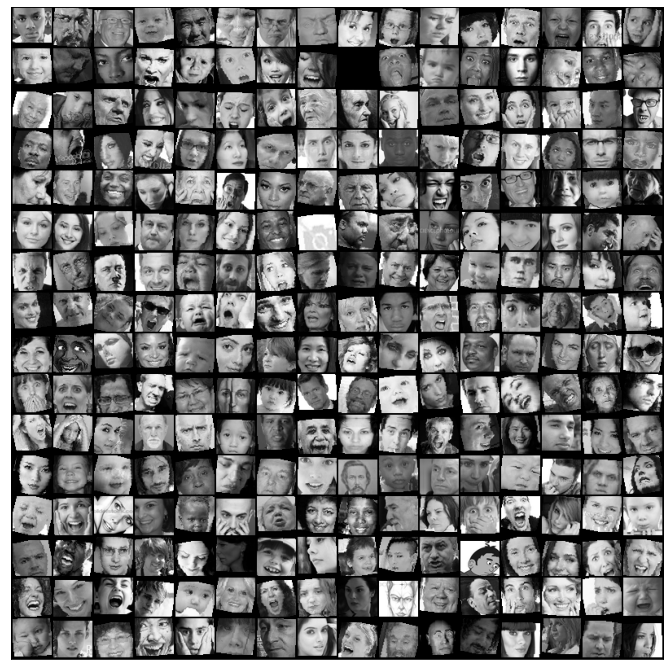

In [134]:
print('one random batch from train_loader set (batch size = {} ): '.format(batch_size) )
show_batch(train_dataloader)

In [135]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()   # torch.device
print(device)

cuda


## CNN Model:

In [137]:
class CNN(nn.Module):   
    def __init__(self, num_classes=7):
        super(CNN, self).__init__()

        self.cnn_layers = nn.Sequential(  # image shapes(1, 48, 48)
            # vgg-16 conv layer 1------(conv1)-----------
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),  # image size will be 

            # vgg-16 conv layer 2------(conv2)-----------
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # vgg-16 conv layer 3------(conv3)-----------
            # nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),

            # vgg-16 conv layer 4------(conv4)-----------
            # nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)

        )
        self.history = {'loss':[], 'val-loss':[]}

        self.linear_layers = nn.Sequential(

            nn.Linear(64 * 12 * 12, 1024),    # input features is (depth * h * w) , output feature is 1024 
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.30),
            nn.Linear(512, num_classes)
            )

    # Defining the forward pass (it's also prediction function)    
    def forward(self, x):
        x = self.cnn_layers(x)
        # flatten the output of conv layers to (batch_size, 512 * 3 * 3)
        x = x.view(x.size(0), -1)       
        output = self.linear_layers(x)
        return output

    def modelSummery(self):
        print(self)

In [143]:
cnn_model = CNN(num_classes=7).to(device)

print('CNN summery:\n')
cnn_model.modelSummery()

CNN summery:

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features

### printing models parammeters:

In [144]:
for par in cnn_model.parameters():
    print(par)

Parameter containing:
tensor([[[[-0.1038,  0.3102,  0.3295],
          [ 0.2587,  0.0091,  0.2159],
          [-0.1738, -0.2747,  0.1327]]],


        [[[-0.1682, -0.0016, -0.2817],
          [-0.1745,  0.0431,  0.0590],
          [-0.0762,  0.0834,  0.3289]]],


        [[[ 0.0744, -0.1051, -0.3285],
          [-0.1494,  0.0996,  0.2281],
          [ 0.0885, -0.1604,  0.2305]]],


        [[[-0.3036, -0.2674,  0.2067],
          [ 0.2142,  0.1426, -0.0403],
          [-0.2656, -0.1134,  0.0504]]],


        [[[-0.0785, -0.3210,  0.2255],
          [-0.2315,  0.0359, -0.0495],
          [-0.2941,  0.3231,  0.2126]]],


        [[[-0.0222, -0.0388, -0.2923],
          [-0.1916, -0.0928,  0.0705],
          [-0.1960,  0.2726, -0.2179]]],


        [[[ 0.1255,  0.1069,  0.3259],
          [-0.2407,  0.0932,  0.2318],
          [ 0.1400, -0.0574, -0.1636]]],


        [[[ 0.1932,  0.2157,  0.0579],
          [-0.0714,  0.2398, -0.2256],
          [ 0.0067, -0.1038,  0.3152]]],


        [[

In [145]:
loss_func = nn.CrossEntropyLoss() 
opt = optim.Adam(cnn_model.parameters(), lr = 0.001)   
# opt2 = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)
print(loss_func)
print(opt)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [146]:
def train(n_epoch, opt, model, loss_func, train_loader, log):    # implements pytorch's training loop. 
    for epoch in range(1, n_epoch + 1):
        loss_train = 0.0
        model.train()  # set the model to training mode.
        for batch_num, (images, labels) in enumerate(train_loader):

            images = images.to(device=device)     # moving batch of images to the gpu
            labels = labels.type(torch.FloatTensor)
            labels = labels.to(device=device)     # moving labels to the gpu

            preds = model(images)
            loss = loss_func(preds, labels)
            opt.zero_grad()
            loss.backward()     # calculates backprop
            opt.step()          # updates the model parammeters.

            loss_train += loss.item()
            if log:
                if epoch == 1 or epoch % 2 == 0:
                    print( '{} Epoch {}, Training loss: {}'.format(
                    datetime.datetime.now(), epoch, loss_train / len(train_loader)) )

        model.history['loss'].append(loss.item())   # appends loss on train set during training of model in each epoch.
        

In [147]:
train(60, opt, cnn_model, loss_func, train_dataloader, log=True)

2021-12-06 23:44:42.016923 Epoch 1, Training loss: 0.021302246811366318
2021-12-06 23:44:42.472682 Epoch 1, Training loss: 0.04661510958529935
2021-12-06 23:44:42.929876 Epoch 1, Training loss: 0.06965124016941183
2021-12-06 23:44:43.355047 Epoch 1, Training loss: 0.09109657589751895
2021-12-06 23:44:43.809930 Epoch 1, Training loss: 0.11318430806150531
2021-12-06 23:44:44.224636 Epoch 1, Training loss: 0.13439074601277268
2021-12-06 23:44:44.643790 Epoch 1, Training loss: 0.1553649406621952
2021-12-06 23:44:45.051089 Epoch 1, Training loss: 0.1757025647871565
2021-12-06 23:44:45.447494 Epoch 1, Training loss: 0.19573261950275686
2021-12-06 23:44:45.875467 Epoch 1, Training loss: 0.21620404602277396
2021-12-06 23:44:46.284511 Epoch 1, Training loss: 0.23624441647293545
2021-12-06 23:44:46.741790 Epoch 1, Training loss: 0.25650320666851384
2021-12-06 23:44:47.152912 Epoch 1, Training loss: 0.27600367588571983
2021-12-06 23:44:47.560825 Epoch 1, Training loss: 0.294805376836569
2021-12-0

In [148]:
sum(cnn_model.history['loss'])/ len(cnn_model.history['loss'])

0.9113722364107768

Text(0, 0.5, 'loss')

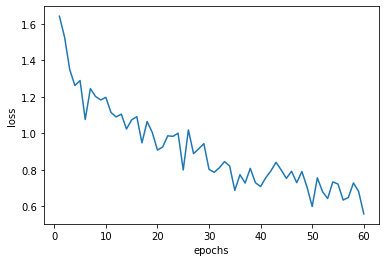

In [149]:
plt.plot(range(1, len(cnn_model.history['loss']) + 1), cnn_model.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [ ]:
# tst = iter(train_dataloader)
# batch = tst.next()
# batch_images , batch_labels = batch[0].to(device=device), batch[1].to(device=device)
# outputs = cnn_model(batch_images)

In [ ]:
# batch_labels[3]

In [150]:
def validate(model, train_loader, val_loader):
    model.eval()
    val_acc = []
    train_acc = []

    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in loader:
                
                images = images.to(device=device)     # moving batch of images to the gpu
                labels = labels.type(torch.FloatTensor)
                labels = labels.to(device=device)     # moving labels to the gpu

                outputs = model(images)

                loss = loss_func(outputs, labels)

                predicted = outputs.argmax(axis=1)
                total += labels.shape[0]
                correct += int((predicted == labels.argmax(axis=1)).sum())
                # correct += int((predicted == labels).sum())

                print("Accuracy {}: {:.2f}".format(name , correct / total))

                if name == "train":
                    train_acc.append(correct / total)

                if name == "val":
                    val_acc.append(correct / total)
                    model.history['val-loss'].append(loss.item())
    return train_acc, val_acc

In [151]:
train_acc, val_acc = validate(cnn_model, train_dataloader, val_dataloader)

Accuracy train: 0.80
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.80
Accuracy train: 0.80
Accuracy train: 0.80
Accuracy train: 0.80
Accuracy train: 0.80
Accuracy train: 0.80
Accuracy train: 0.80
Accuracy train: 0.80
Accuracy train: 0.80
Accuracy train: 0.80
Accuracy train: 0.80
Accuracy train: 0.80
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.80
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy train: 0.79
Accuracy trai

Text(0, 0.5, 'loss')

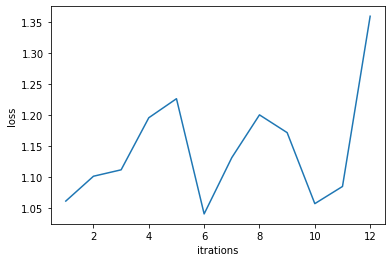

In [152]:
plt.plot(range(1, len(cnn_model.history['val-loss']) + 1), cnn_model.history['val-loss'])
plt.xlabel('itrations')
plt.ylabel('loss')

In [153]:
print('avg train accuracy: ', sum(train_acc)/len(train_acc))
print('\navg val accuracy: ', sum(val_acc)/len(val_acc))

avg train accuracy:  0.790975526021287

avg val accuracy:  0.6135772881731932


## saving model's parammeters:

In [33]:
torch.save(cnn_model.state_dict(), "/content/cnn_model_params.pt")